# QC - sc methylation

### initialize definitions

In [1]:
suppressMessages(suppressWarnings(source(here::here("code/init.R"))))

In [2]:
suppressMessages(suppressWarnings(load_cgdb()))

In [3]:
db

cgdb object
21,342,746 CpGs X 24,179 cells

--- root (@db_root): /net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/Dnmt3ab_EB/methylation/data/cgdb



In [3]:
samp_levels <- c("d5_3a", "d5_3b", "d5_wt", "e7.5_ecto", "e7.5_meso", "e7.5_endo")

In [5]:
sc_stats <- db_f@cells %>% 
    filter(day %in% c("d5", "e7.5"))

In [6]:
invivo_sort <- fread(here("data/cells_germ_layer_invivo.tsv")) %>% as_tibble()

In [7]:
sc_stats <- sc_stats %>% 
    left_join(invivo_sort) %>% 
    replace_na(replace = list(germ_layer = "other")) %>%
    mutate(sort = ifelse(day == "e7.5", germ_layer, sort)) 

Joining, by = "cell_id"


> Note that for cell cycle we use specific experiments with similar cell cycle profile

In [8]:
sc_stats %>% count(day, line, sort) 

day,line,sort,n
<chr>,<chr>,<chr>,<int>
d5,ko3a,CXCR4+EPCAM+,372
d5,ko3a,CXCR4-EPCAM+,372
d5,ko3a,index,1851
d5,ko3b,CXCR4+EPCAM+,372
d5,ko3b,CXCR4-EPCAM+,372
d5,ko3b,index,1837
d5,wt,CXCR4+EPCAM+,372
d5,wt,CXCR4-EPCAM+,371
d5,wt,index,2567


## Distribution of %CHH

### Extended Data Figure 9B

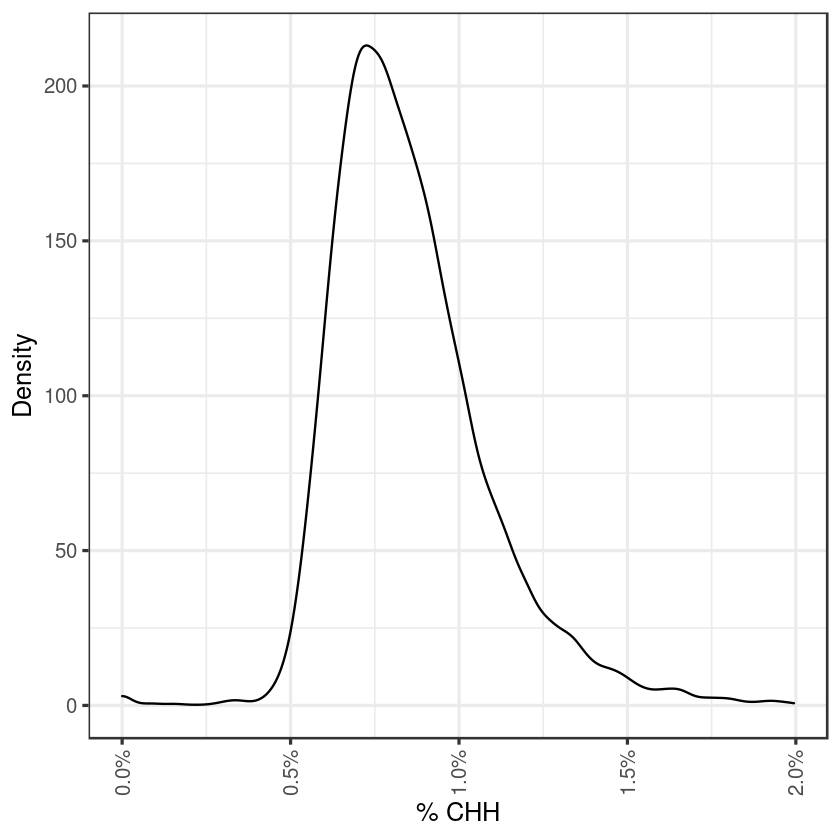

In [9]:
p <- sc_stats %>%    
    ggplot(aes(x=CHH)) + 
        geom_density() + 
        scale_x_continuous(labels=scales::percent) + 
        vertical_labs() + 
        xlab("% CHH") + 
        ylab("Density")
p

## Number of cells

### Extended Data Figure 9A

In [10]:
sc_stats %>% 
    filter(cg_num >= 2e4) %>% 
    organize_sc_samp_id() %>% 
    count(samp_id, day, line)

sc_stats %>% 
    filter(cg_num >= 2e4) %>% 
    organize_sc_samp_id() %>% 
    count(day)

samp_id,day,line,n
<chr>,<chr>,<chr>,<int>
d5_3a,d5,ko3a,2217
d5_3b,d5,ko3b,2197
d5_wt,d5,wt,2984
e7.5,e7.5,mouse,2146


day,n
<chr>,<int>
d5,7398
e7.5,2146


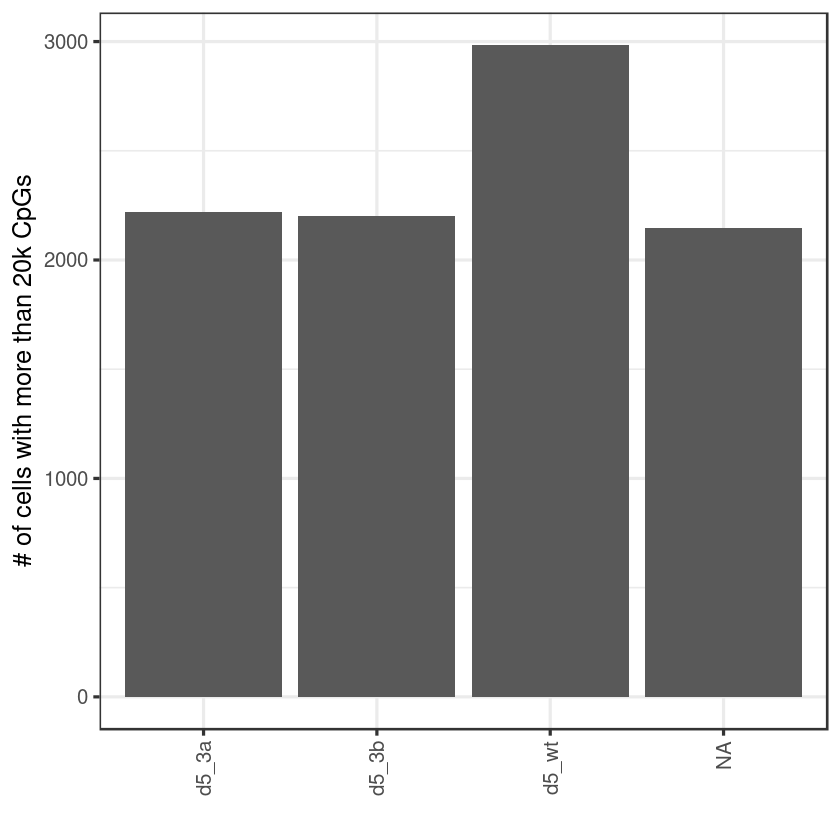

In [11]:
p <- sc_stats %>% 
    filter(cg_num >= 2e4) %>% 
    organize_sc_samp_id() %>% 
    count(samp_id, day, line) %>%
    mutate(samp_id = factor(samp_id, levels=samp_levels)) %>%
    ggplot(aes(x=samp_id, y=n)) + 
        geom_col() + 
        vertical_labs() + 
        ylab("# of cells with more than 20k CpGs") + 
        xlab("")
        
p

## Number of CpGs

### Extended Data Figure 9C

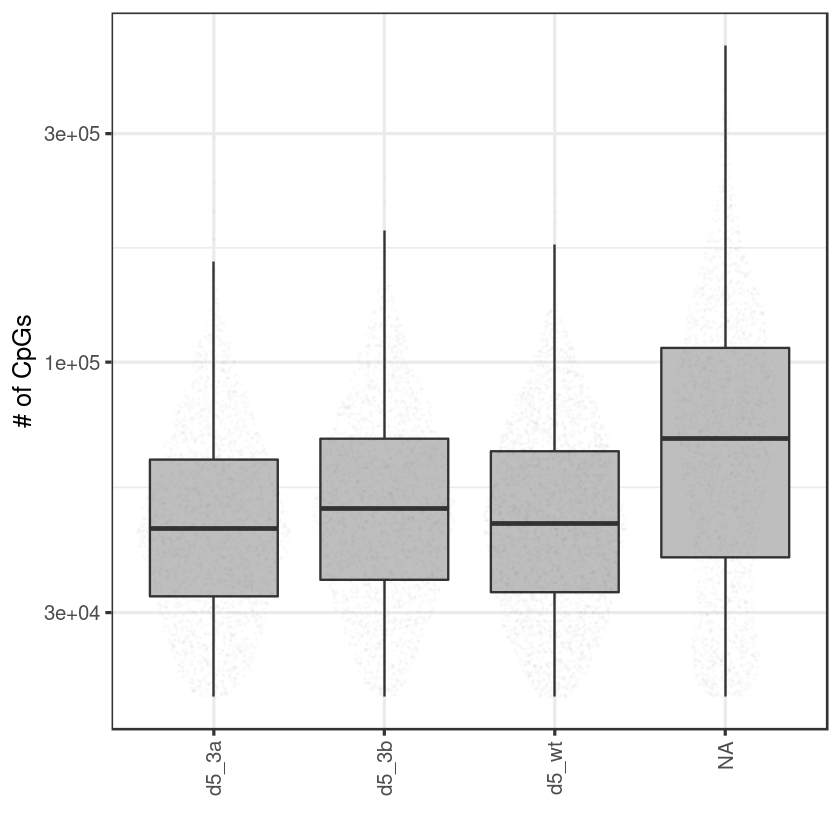

In [12]:
p <- sc_stats %>% 
    filter(cg_num >= 2e4) %>% 
    organize_sc_samp_id() %>%     
    mutate(samp_id = factor(samp_id, levels=samp_levels)) %>%
    ggplot(aes(x=samp_id, y=cg_num)) + 
        geom_boxplot(fill="gray", outlier.shape = NA) + 
        scale_y_log10(labels=scales::scientific) + 
        ggforce::geom_sina(size=0.001, alpha=0.01) + 
        vertical_labs() + 
        ylab("# of CpGs") + 
        xlab("")
        
p

## Sorting plots

In [13]:
facs_df <- sc_stats %>%         
    filter(!is.na(APC_A), !is.na(BV421_A)) %>% 
    group_by(sort_date) %>%
    mutate(EPCAM = log2(abs(min(APC_A, na.rm=TRUE)) + 10 + APC_A), CXCR4 = log2(abs(min(BV421_A, na.rm=TRUE)) + 10 + BV421_A)) %>% 
    replace_na(replace = list(gate = "no_gate")) %>% 
    ungroup() %>% 
    filter(cpg_num >= 2e4) 

facs_df_e7.5 <- facs_df %>% filter(day == "e7.5")
facs_df_d5 <- facs_df %>% filter(day == "d5")

### Extended Data Figure 9D

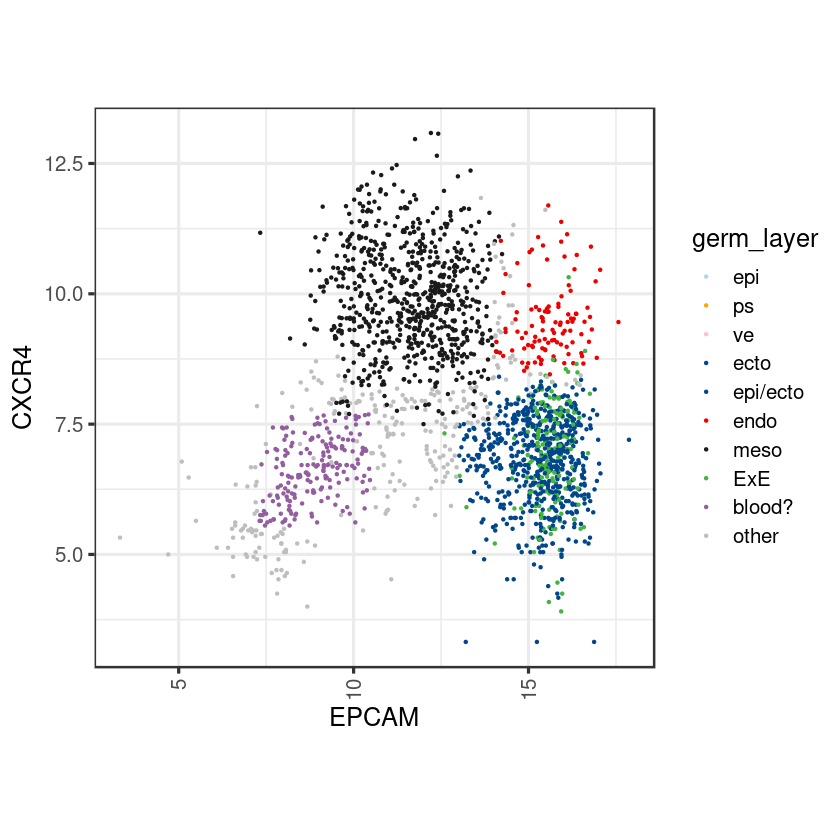

In [14]:
options(repr.plot.width = 7, repr.plot.height = 7)
p_7.5 <- facs_df_e7.5 %>% 
    
    ggplot(aes(x=EPCAM, y=CXCR4, color=germ_layer)) + 
        geom_point(size=0.2) + 
        scale_color_manual(values=germ_layer_colors) + 
        theme(aspect.ratio=1)
p_7.5

### Extended Data Figure 9E

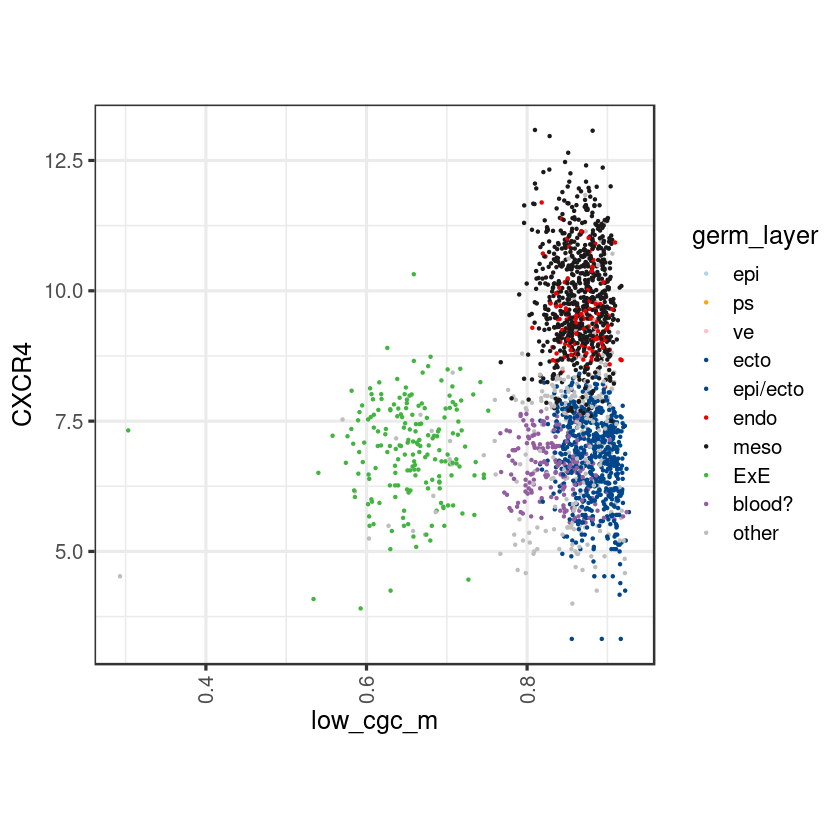

In [15]:
options(repr.plot.width = 7, repr.plot.height = 7)
p_meth_7.5 <- facs_df_e7.5 %>% 
    ggplot(aes(x=low_cgc_m, y=CXCR4, color=germ_layer)) + 
        geom_point(size=0.2) + 
        scale_color_manual(values=germ_layer_colors) + 
        theme(aspect.ratio=1)
p_meth_7.5

## Early/Late coverage per cell (e7.5)

In [17]:
df_ord_invivo <- fread(here("output/cell_cycle/segmented.tsv")) %>% filter(day == "e7.5") %>% mutate(germ_layer = factor(line, levels=c("ecto", "meso", "endo")))

### Extended Data Figure 9F

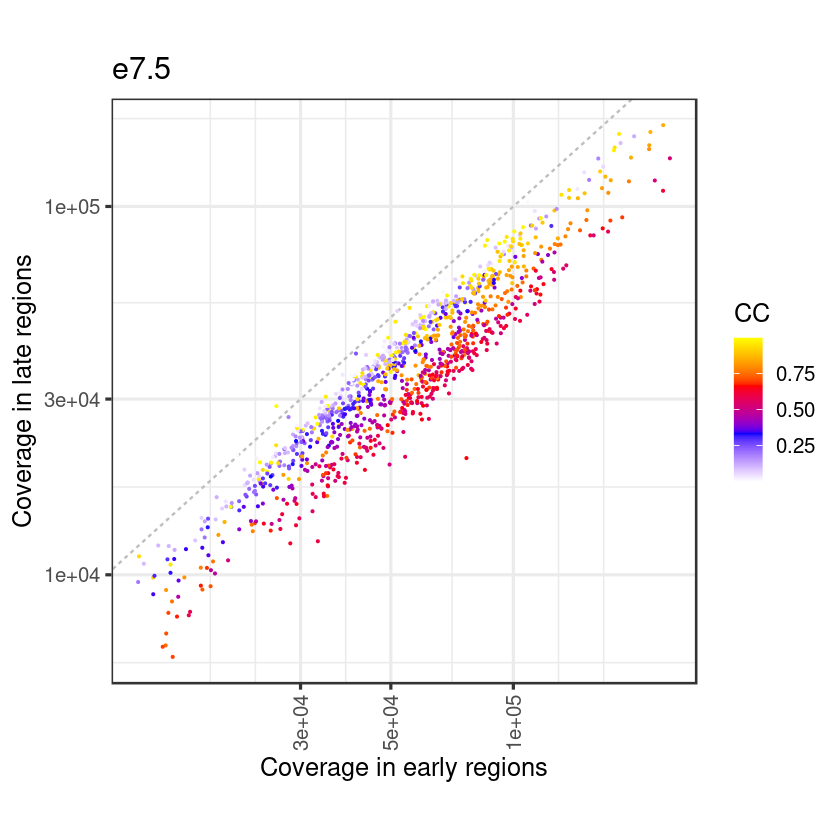

In [18]:
p <- df_ord_invivo %>% 
    ggplot(aes(x=early, y=late, color=ord2)) + 
        geom_abline(linetype="dashed", color="gray") +     
        geom_point(size=0.1) + 
        scale_color_gradientn(name = "CC", colors=c("white", "blue", "red", "yellow")) +         
        theme(aspect.ratio=1) +
        scale_x_log10(labels=scales::scientific) + 
        scale_y_log10(labels=scales::scientific) + 
        vertical_labs() + 
        xlab("Coverage in early regions") + 
        ylab("Coverage in late regions") + 
        ggtitle("e7.5")
p      